# De Novo Design of Potential Binders of [Serotonin 1A (5-HT1A) Receptor](https://gpcrdb.org/protein/5ht1a_human/) with [DrugEx](https://pubs.acs.org/doi/10.1021/acs.jcim.3c00434)

In this tutorial, we showcase the most basic DrugEx model for the design of novel 5-HT1A ligands. This model is a simple recurrent neural network (RNN). RNNs are one of the older language models that can be adapted for molecular generation. However, there are many similar models and packages out there each with its own caveats and benefits. Therefore, it is generally a good idea to combine multiple approaches in real world applications because the overlap of the generated compounds between different methods is usually very small. DrugEx itself also provides multiple distinct methods so feel free to experiment with them as well.

*Serotonin* is the endogenous ligand of 5-HT1A so it makes sense to get a bit more familiar with its structure:

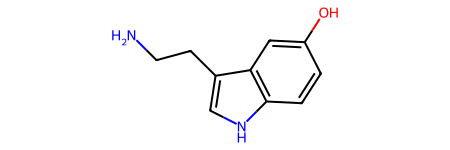

In [1]:
from rdkit import Chem

Chem.MolFromSmiles("C1=CC2=C(C=C1O)C(=CN2)CCN")

The binding pose of serotonin is known and there is a structure available ([7E2Y](https://www.rcsb.org/structure/7e2y)):

In [2]:
from IPython.display import IFrame

IFrame('https://www.rcsb.org/3d-view/7E2Y?preset=ligandInteraction&label_asym_id=E', width='100%', height='600')

An example of a known efficacious ligand would be *Vilazodone*:

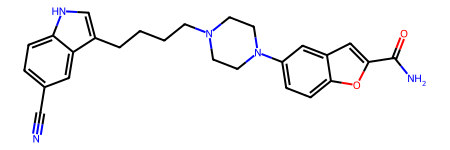

In [3]:
Chem.MolFromSmiles("N#Cc5ccc4[nH]cc(CCCCN3CCN(c2ccc1oc(C(N)=O)cc1c2)CC3)c4c5")

The binding pose of vilazodone is also known and there is a structure available ([8FYL](https://www.rcsb.org/structure/7e2y)):

In [4]:
from IPython.display import IFrame

IFrame('https://www.rcsb.org/3d-view/8FYL?preset=ligandInteraction&label_asym_id=F', width='100%', height='600')

Therefore, there is some structural information about the target and some of its bound ligands, but in this tutorial we will use a purely ligand-based approach that leverages the abundance of available ligand bioactivity data on this highly explored target. However, let's first get more familiar with the [DrugEx package](https://github.com/CDDLeiden/DrugEx) before we start with the core of the tutorial. You will need a machine equipped with a compatible NVIDIA graphics card. DrugEx is built on the [`PyTorch`](https://pytorch.org/) deep learning library, which we can use to check if the compatible [NVIDIA CUDA](https://en.wikipedia.org/wiki/CUDA) interface is available:

In [5]:
import torch

assert torch.cuda.is_available()

If all is well, there is nothing stopping us from generating compounds already:

In [6]:
import os
from drugex.training.generators import SequenceRNN
from drugex.data.corpus.vocabulary import VocSmiles

MODELS_PR_PATH = "data/models/pretrained/smiles-rnn/Papyrus05.5_smiles_rnn_PT/" # path to the previously downloaded RNN model folder

voc = VocSmiles.fromFile(os.path.join(MODELS_PR_PATH, "Papyrus05.5_smiles_rnn_PT.vocab"), encode_frags=False) # loading vocabulary of tokens
pretrained = SequenceRNN(voc, is_lstm=True) # random model initialization
pretrained.loadStatesFromFile(os.path.join(MODELS_PR_PATH, "Papyrus05.5_smiles_rnn_PT.pkg")) # pretrained weight initialization

/home/sichom/software/micromamba/envs/8add-chemspace-denovo/lib/python3.12/site-packages/drugex/training/interfaces.py:322: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sel

The RNN model requires a vocabulary of tokens to be provided. You can open this file and see the tokens defined in it. These are the words of the SMILES language that we use to define structures of molecules. What the model learned is how to combine these words into viable sentences (chemical structures) in the SMILES language. The data saved in the .pkg file are the weights (learned states) of the model that define the learned parameters and tell the model how to combine the tokens in the vocabulary in the correct way to generate a random compound that resembles known chemistry.

## Generating a Random Set of Compounds

Using the model to generate compounds is very easy:

In [7]:
generated_pretrained = pretrained.generate(num_samples=1000)
generated_pretrained

Generating molecules:   0%|          | 0/1000 [00:00<?, ?it/s]

,SMILES,Valid
0,O=C(c1ccco1)N(c1ccccc1)C1CCN(Cc2ccccc2)CC1,1.0
1,OCCN(CCO)c1ccc(Cc2ccccc2)cc1,1.0
2,CCCCCCCC(NC(=O)C1CC2(C)CCC1C2(C)C)c1ccc(OCc2cc...,1.0
3,O=C1Nc2ccc(Cl)cc2C(c2ccccc2)=NC1CCCCO,1.0
4,COc1cnc(CNC(N)=S)cn1,1.0
...,...,...
995,NC(=O)c1cccc2c1C(=O)N(C1CCN(Cc3ccccc3)CC1)C2,1.0
996,CCn1cc(C(=O)OCC(=O)Nc2ccc(OC)c(Cl)c2)c(=O)c2cc...,1.0
997,NS(=O)(=O)c1ccc(N2C(=O)c3cc4c5cc3N=C(C=C(Cl)C=...,1.0
998,CCCn1c(=O)c2nc(-c3ccc(OCC(=O)O)cc3)[nH]c2n(CCC...,1.0


### Comparison with a Set of Known 5-HT1A Ligands

We will now merge the generated structures with the data set of experimental values that we used previously to train our QSAR model:

In [8]:
import pandas as pd

# read the previous data and label it
df_P08908 = pd.read_table("./data/data/P08908_LIGANDS_nostereo.tsv")
df_P08908["Set"] = "P08908"

# label the generated data
generated_pretrained["Set"] = "Generated (pretrained)"

# merge the two data sets
df_all_sets = pd.concat([generated_pretrained, df_P08908])
df_all_sets.Set.unique()

array(['Generated (pretrained)', 'P08908'], dtype=object)

We will use the UMAP algorithm to compare these two chemical spaces. You should already know [how to create chemical space visualizations](../chemspace/tutorial.ipynb) so the following code should not surprise you. We only wrap the code into a function because we will use it at a few more places in this tutorial:

In [9]:
from qsprpred.data import MoleculeTable
from qsprpred.data.descriptors.fingerprints import MorganFP
from scaffviz.clustering.manifold import UMAP
from scaffviz.depiction.plot import Plot

def plot_spaces(df, name, port, color_by="Set", card_data=["Set", "pchembl_value_Median"]):
    mt = MoleculeTable(
        name=name, 
        df=df.copy()
    )
    morgan_fp = MorganFP(3, 2048)
    mt.addDescriptors([morgan_fp])
    plt = Plot(UMAP(n_neighbors=30, min_dist=0.4, metric="jaccard", random_state=42))
    return mt, plt.plot(
        mt,
        color_by=color_by,
        recalculate=True,
        card_data=card_data,
        port=port,
        viewport_height=800
    )

Plotting itself is then a breeze:

In [10]:
mt, plt = plot_spaces(df_all_sets, "Pretrained+P08908", 9000)

/home/sichom/software/micromamba/envs/8add-chemspace-denovo/lib/python3.12/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/home/sichom/software/micromamba/envs/8add-chemspace-denovo/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Dash is running on http://127.0.0.1:9000/



In [11]:
PLOT_DATA_DIR = "." # replace '.' with '/mnt/c/Users/student/Documents' on WSL
mt.getDF().to_csv(f"{PLOT_DATA_DIR}/{mt.name}.csv")

We can see that the general pretrained model generated a chemical space that does not really have a clear structure, at least not in comparison to our set of 5-HT1A-specific compounds, for which bioactivity data is available. Since we already have the data set loaded, it might be interesting to actually look at the compounds containing the dopamine structure. By doing that, we can also discover a few more popular patterns in these kinds of ligands (note the locations of piperidine and piperazine rings in these ligands):

In [12]:
from qsprpred.plotting.grid_visualizers import smiles_to_grid, interactive_grid

# seeking the serotonin scaffold
smiles_to_grid(MoleculeTable(df=df_P08908, name="P08908").searchWithSMARTS(["c1c(O)ccc2c1c(CCN)cn2"]).smiles, impl=interactive_grid)

MolGridWidget()

## Fine-Tuning with Transfer Learning

![image.png](https://raw.githubusercontent.com/CDDLeiden/DrugEx/bf61ce71db96bdfe25cc2832ec0d4cf0b1142db4/tutorial/images/TL.drawio.svg)

In transfer learning, we use a pretrained model on one task and then fine-tune it for another task with different data. In the context of our project it means fine-tuning the general pretrained Papyrus model woth our target-specific 5-HT1A data. In order to do that, we first need to use the DrugEx standardizer to make the data consistent with the way it was prepared for the pretrained model as well:

In [13]:
from drugex.data.processing import Standardization

N_PROCESSES = 8 # number of CPU cores to use
CHUNK_SIZE = 1000 # largest chunk per CPU core (regulates RAM usage)

standardizer = Standardization(n_proc=N_PROCESSES, chunk_size=CHUNK_SIZE)
smiles_ft = standardizer.apply(df_P08908.SMILES)
smiles_ft[0:10]

Standardizing molecules (batch processing):   0%|          | 0/1 [00:00<?, ?it/s]

['O=C(NC1CCC(CCN2CCN(c3nsc4ccccc34)CC2)CC1)c1ccco1',
 'COc1ccc(CN2CC=C(c3c[nH]c4ccc(OC(C)C)cc34)CC2)cc1',
 'COc1ccccc1N1CCN(CCCCCN2C(=O)c3ccccc3S2(=O)=O)CC1',
 'Fc1ccc2c(C3CCC(N4CCN(c5cccc6[nH]ccc56)CC4)CC3)c[nH]c2c1',
 'O=S(=O)(c1cccc2ncccc12)N1CCCC1CCN1CCC(c2noc3cc(F)ccc23)CC1',
 'c1ccc(OCCNCC2CCOC(c3ccccc3)(c3ccccc3)O2)cc1',
 'COc1cccc(Sc2ccccc2N2CCNCC2)c1',
 'CC(C)Oc1ccccc1OCCNCc1cccc(C2CCCC2)c1',
 'O=C(NCCCCN1CCN(c2cccc(Cl)c2Cl)CC1)c1cc2ccc1CCc1ccc(cc1)CC2',
 'Cc1ccc2c(N3CCN(CCCc4cccc5c4OCC(=O)N5)CC3)cccc2n1']

Then this data needs to be encoded for the DrugEx RNN model:

In [14]:
from drugex.data.processing import CorpusEncoder, RandomTrainTestSplitter
from drugex.data.corpus.corpus import SequenceCorpus
from drugex.data.datasets import SmilesDataSet
from drugex.logs import logger
logger.setLevel('ERROR')

DATA_DIR = "data/datasets/encoded/rnn/"
os.makedirs(DATA_DIR, exist_ok=True)

voc = VocSmiles.fromFile(f"{MODELS_PR_PATH}/Papyrus05.5_smiles_rnn_PT.vocab", encode_frags=False)
encoder = CorpusEncoder( # CorpusEcoder uses the supplied corpus class to encode tokens for the new data set
    SequenceCorpus, # The corpus class implements how each SMILES string is divided into words by the vocabulary
    {
        # arguments of the SequenceCorpus
        'vocabulary': voc, # used vocabulary
        'update_voc': False, # if False, the vocabulary stays fixed (no new tokens are added to it)
        'throw': True # compounds containing unknown tokens are thrown out of the resulting data set

    },
    n_proc=N_PROCESSES,
    chunk_size=CHUNK_SIZE
)

data_collector = SmilesDataSet(os.path.join(DATA_DIR, 'ligand_corpus.tsv'), rewrite=True)
encoder.apply(smiles_ft, collector=data_collector)
data_collector

SequenceCorpus (batch processing):   0%|          | 0/1 [00:00<?, ?it/s]

DrugEx fitting also requires a validation set, but since we are not tuning hyperparameters of the model, we will simply use a sample of the training data here:

In [15]:
pd.DataFrame(data_collector.getData()).sample(1000).to_csv(f"{DATA_DIR}_test_dummy.tsv", header=True, index=False, sep='\t')
data_set_test = SmilesDataSet(f"{DATA_DIR}_test_dummy.tsv", voc=voc)
data_set_test

Then we can simply start training on the pretrained model with this data:

In [16]:
from drugex.training.monitors import FileMonitor

MODEL_DIR = "data/models/finetuned/rnn"
BATCH_SIZE = 256

loader_train = data_collector.asDataLoader(batch_size=BATCH_SIZE) # training data
loader_test = data_set_test.asDataLoader(batch_size=BATCH_SIZE) # validation data (just a sample of training in our case)
ft_path = os.path.join(MODEL_DIR, 'P08908_finetuned')
finetuned = SequenceRNN(voc, is_lstm=True)
finetuned.loadStatesFromFile(os.path.join(MODELS_PR_PATH, 'Papyrus05.5_smiles_rnn_PT.pkg')) # starting from pretrained model
monitor = FileMonitor(ft_path, save_smiles=True, reset_directory=True) # monitors training and generates output files
finetuned.fit(loader_train, loader_test, epochs=10, monitor=monitor, patience=30) # runs training, only 10 epochs for speed
voc.toFile(os.path.join(MODEL_DIR, 'P08908_finetuned.vocab'))

/home/sichom/software/micromamba/envs/8add-chemspace-denovo/lib/python3.12/site-packages/drugex/training/interfaces.py:322: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Fitting model:   0%|          | 0/10 [00:00<?, ?it/s]

Exploring training output:

In [17]:
df_info = pd.read_csv(f'{MODEL_DIR}/P08908_finetuned_fit.tsv', sep='\t')
df_info.head()

,Epoch,loss_train,loss_valid,valid_ratio,best_epoch
0,1,1.061,0.892,0.592,1
1,2,0.252,0.229,0.381,2
2,3,0.186,0.169,0.578,3
3,4,0.162,0.144,0.717,4
4,5,0.131,0.130,0.705,5


Decreasing loss indicates good training progress (generated structures become more similar to the training data):

<Axes: >

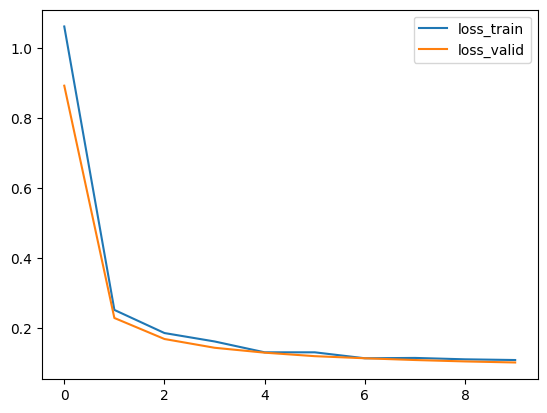

In [18]:
df_info[['loss_train', 'loss_valid']].plot.line()

## Generating Structures with the Fine-Tuned Model

It seems that the model quickly converged (courtesy of transfer learning) so we can generate a sample of 1000 molecules to compare with our training set distribution:

In [19]:
df_finetuned = finetuned.generate(num_samples=1000)
df_finetuned["Set"] = "Fine-tuned"
df_all_sets = pd.concat([df_all_sets, df_finetuned])
df_all_sets.Set.unique()

Generating molecules:   0%|          | 0/1000 [00:00<?, ?it/s]

array(['Generated (pretrained)', 'P08908', 'Fine-tuned'], dtype=object)

Let's compare with a plot again:

In [20]:
mt, plt = plot_spaces(df_all_sets, "Pretrained+P08908+FT", 9001)

/home/sichom/software/micromamba/envs/8add-chemspace-denovo/lib/python3.12/site-packages/umap/umap_.py:1887: UserWarning:

gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable

/home/sichom/software/micromamba/envs/8add-chemspace-denovo/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Dash is running on http://127.0.0.1:9001/



In [21]:
mt.getDF().to_csv(f"{PLOT_DATA_DIR}/{mt.name}.csv")

It looks like the model indeed converged on the chemical space more likely occupied by 5-HT1A ligands. In addition, using a QSAR model developed previously:

In [22]:
from qsprpred.models import QSPRModel

qsar_model = QSPRModel.fromFile("./data/models/qsar/P08908_LIGANDS_nostereo_XGBRegressor/P08908_LIGANDS_nostereo_XGBRegressor_meta.json")
qsar_model

we can observe that our generated set also has a similar distribution of predicted $pKi$ values:

In [23]:
df_all_sets["PKi_predicted"] = qsar_model.predictMols(df_all_sets.SMILES)

<Axes: >

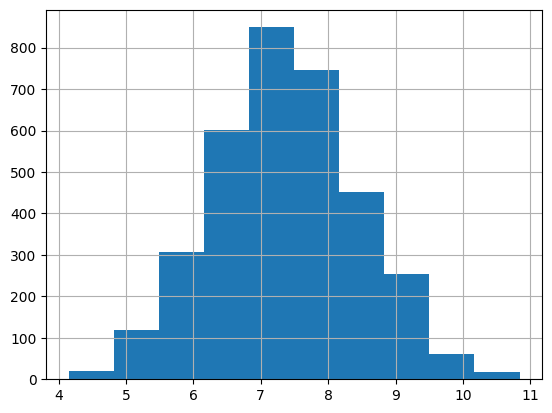

In [24]:
df_all_sets[df_all_sets.Set == "P08908"].PKi_predicted.hist()

<Axes: >

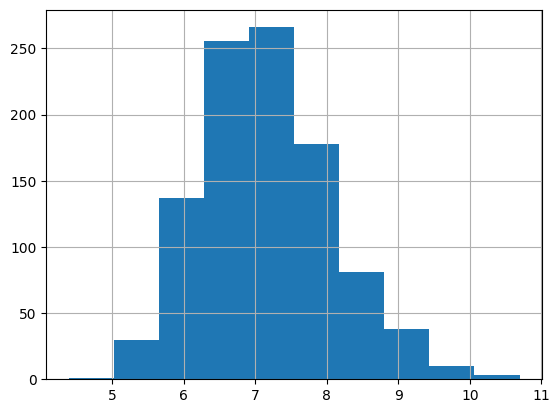

In [25]:
df_all_sets[df_all_sets.Set == "Fine-tuned"].PKi_predicted.hist()

However, upon a closer look, the fine-tuned set seems to have a slightly lower mean predicted activity than the original experimental data set:

In [26]:
df_all_sets[df_all_sets.Set == "P08908"].PKi_predicted.mean(), df_all_sets[df_all_sets.Set == "Fine-tuned"].PKi_predicted.mean()

(7.372409, 7.156361)

which we can also confirm with statistical significance:

In [27]:
from scipy import stats

stats.ttest_ind(df_all_sets[df_all_sets.Set == "P08908"].PKi_predicted, df_all_sets[df_all_sets.Set == "Fine-tuned"].PKi_predicted, alternative="greater")

TtestResult(statistic=5.753442716889062, pvalue=4.667078924781027e-09, df=4426.0)

Therefore, we are generating a lot of compounds that are less active and, thus, not of interest. One way to tackle this would be to filter our fine-tuning data on bilogical activity and only keep the most prospective ligands to train our generator with, but then we are shrinking our training set, which makes our generated set much less diverse and the training could also become more unstable with small training set size. Also, the fact that we have low affinity ligands in our training data does not mean these could not be optimized into high affinity ones. It is possible some possible alterations to the scaffold were missed or there simply were not enough resources. Therefore, it would be highly desirable to also have a method that can optimize the predicted binding affinity and train our generative model to output scaffolds that are active with a higher likelihood. The method we will showcase here is called **reinforcement learning** and is probably one of the most popular methods for this task in the generative models used for de novo drug design. However, as we will see, this methodology still has some caveats and **the main challenge is to configure the optimization process so that the model generates plausible chemical structures of putatively active molecules with a high degree of synthetic accessibilty, but still different enough from the training data to consider them interesting from the current state-of-the-art point of view.**

## Generating Activite and Synthetically Accessible Structures with Reinforcement Learning and Pareto Optimization

As stated above, our objective is to generate novel structures of potentially active ligands that we can also easily prepare and test. Therefore, we will need two scoring functions that will quantify these two objectives:

In [28]:
from drugex.training.scorers.qsprpred import QSPRPredScorer
from drugex.training.scorers.properties import Property

qsprpred_scorer = QSPRPredScorer(qsar_model) # affinity (pKi) to the 5-HT1A receptor
sascore_scorer = Property("SA") # synthetic accessibility (molecule complexity) https://jcheminf.biomedcentral.com/articles/10.1186/1758-2946-1-8

The scorers generated above do nothing more than return a score for a set of input molecules:

In [29]:
sample = finetuned.generate(100).SMILES
qsprpred_scorer.getScores(sample)

Generating molecules:   0%|          | 0/100 [00:00<?, ?it/s]

array([6.86223269, 8.51451397, 9.50702477, 7.23362923, 7.53001785,
       7.30629253, 7.14232779, 6.5812583 , 6.72000504, 7.29274893,
       7.34885597, 6.50013924, 8.04381371, 7.40539026, 6.97971106,
       8.15385914, 8.85238838, 7.86562824, 6.762784  , 6.73487902,
       7.8801589 , 6.62979603, 7.21346378, 7.24374485, 7.18200922,
       6.684237  , 6.72112513, 7.64286613, 8.91415882, 7.38451385,
       5.697299  , 9.59908772, 7.71606731, 6.9767499 , 6.46856737,
       9.06277084, 7.04257345, 9.15676403, 7.3761425 , 7.15447664,
       8.03746223, 6.36555815, 6.67368984, 5.45084715, 8.04144955,
       9.34611225, 6.64375353, 8.61109734, 6.02392244, 7.64887619,
       5.97742653, 9.26729584, 7.83857965, 8.80907536, 6.40105295,
       6.80972385, 6.21608114, 6.14002609, 7.22290516, 7.14747906,
       7.23464251, 7.62928629, 6.93733692, 8.99460793, 8.91466713,
       7.17532015, 6.94122171, 6.97021818, 6.33188534, 7.37787437,
       5.25055552, 6.75417137, 5.59507036, 7.87351561, 6.76031

In [30]:
from rdkit import Chem

sascore_scorer.getScores([Chem.MolFromSmiles(smile) for smile in sample]) # requires RDKit molecule directly due to a bug

array([2.84853484, 1.94291649, 2.73894987, 2.54918486, 1.82394038,
       3.87370271, 2.53709498, 2.08695331, 3.39232509, 1.8414858 ,
       2.98112609, 3.3193223 , 3.26606885, 2.99042002, 2.50804952,
       2.47382241, 2.14487054, 2.29849294, 1.77729163, 2.25927121,
       2.09975776, 2.60357155, 2.11724435, 3.0178415 , 2.98266682,
       2.07058527, 3.69438892, 1.85577548, 2.14048284, 2.16144831,
       2.84169953, 2.8968726 , 2.26126556, 3.24909768, 2.31462856,
       3.67680221, 1.96364184, 2.38578114, 1.93248618, 3.45843219,
       3.25974642, 3.86685126, 2.14663293, 2.09220178, 2.43607656,
       2.79735284, 1.98503481, 2.92401364, 2.58359029, 4.20599063,
       3.5381042 , 2.48906216, 2.62195241, 2.45766047, 1.64811316,
       2.65683325, 2.82321784, 2.02760704, 1.86869714, 2.20101767,
       2.64717568, 2.91033596, 2.85304661, 2.07976694, 2.35479952,
       2.25992492, 2.39652186, 3.48816463, 3.26536426, 2.73374943,
       3.23734545, 1.90091061, 1.99207626, 3.57165638, 2.09054

We will use [Pareto optimization](https://en.wikipedia.org/wiki/Multi-objective_optimization) to balance these two objectives and calculate rewards for the model under the reinforcement learning framework implemented in DrugEx. Based on the rewards, the model adjusts its weights to generate even better compounds in the next iteration. In order for this process to work, we need our objectives to be on the same scale (ideally in the range between 0 and 1). We can easily facilitate this by the use of modifier functions that can also reflect our notion of what is considered a good value for each objective:

### QSAR Objective

Since we are using a regression QSAR model for the $pKi$, the theoretical values for this objective are continuous values from 0 to infinity. However, only values in a certain range are useful for us and we can reflect this with the `ClippedScore` modifier:

In [31]:
from drugex.training.scorers.modifiers import ClippedScore

qsprpred_scorer.setModifier(ClippedScore(lower_x=7.5, upper_x=8.5))
raw = qsprpred_scorer.getScores(sample)
modified = qsprpred_scorer(sample)

<Axes: >

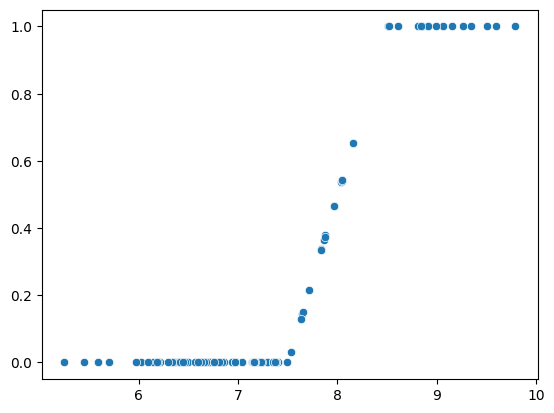

In [32]:
import seaborn as sns

sns.scatterplot(x=raw, y=modified)

Therefore, using this modifier we only give a reward to the model if the predicted value surpasses $pKi = 7.5$ with values surpassing $pKi = 8.5$ giving the maximum reward of 1.

### SA Score Objective

Following the same logic, we can also define a modifier for the synthetic accessibility objective. Even though SA Score also has expected values from 0 to infinity, the higher this score the more complex the molecule. Therefore, we need to give higher reward to molecules with lower SA score and vice versa. In this scheme, we use the `SmoothClippedScore` method to better reflect our notion of how synthetic accessibility is reflected in this score:

In [33]:
from drugex.training.scorers.modifiers import SmoothClippedScore

sascore_scorer.setModifier(SmoothClippedScore(lower_x=4, upper_x=3))
raw = sascore_scorer.getScores([Chem.MolFromSmiles(smile) for smile in sample])
modified = sascore_scorer([Chem.MolFromSmiles(smile) for smile in sample])

<Axes: >

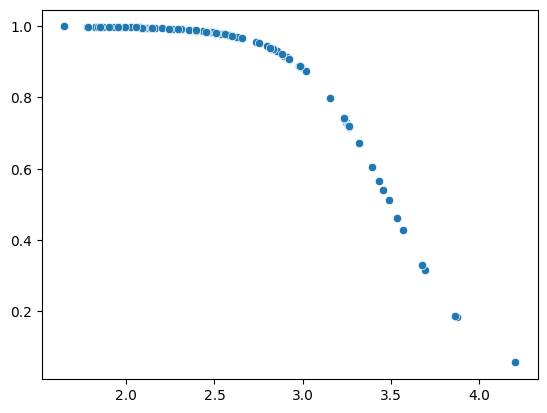

In [34]:
import seaborn as sns

sns.scatterplot(x=raw, y=modified)

It is also useful to observe the distribution of these scores in our training data to gauge the likelihood of our success to optimize these objectives and make adjustments in case our expectations do not reflect reality:

<Axes: >

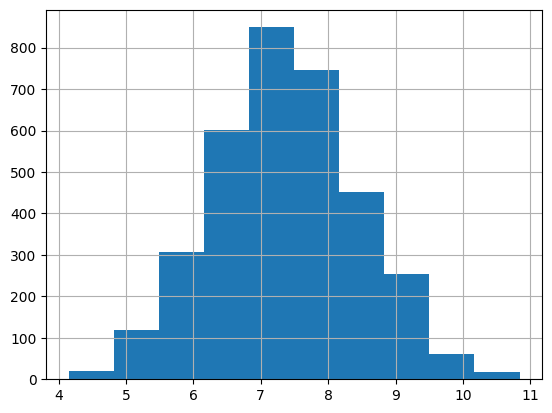

In [35]:
df_all_sets[df_all_sets.Set == "P08908"].PKi_predicted.hist() # predicted pKi values

We can see that in the case of the $pKi$ objective our requirement is to roughly score all above average molecules higher than 0 with strong preference towards more active ones, which makes sense and we can be happy with it.

For the case of SA Score we are also being fairly reasonable with regards to the training data and the `SmoothClippedScore` function reflects the trends we observe:

<Axes: >

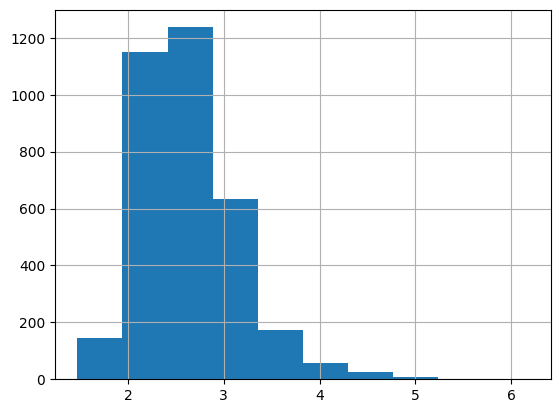

In [36]:
pd.Series(sascore_scorer.getScores([Chem.MolFromSmiles(smile) for smile in df_all_sets[df_all_sets.Set == "P08908"].SMILES])).hist()

### Creating the environment

In reinforcement learning, the assortment of objectives is called the environment while the model that navigates this environment is called the agent. DrugEx has a data structure to create the environment in a relatively easy manner:

In [37]:
from drugex.training.environment import DrugExEnvironment
from drugex.training.rewards import ParetoCrowdingDistance

scorers = [
    qsprpred_scorer,
    sascore_scorer
]
thresholds = [
    # only used in the generated output files, has no effect on training
    0.5,
    0.1
]

environment = DrugExEnvironment(
    scorers, 
    thresholds, 
    reward_scheme=ParetoCrowdingDistance() # defines how diverse solutions are selected in the NSGA-II algorithm
)

All scores can be conveniently obtained as a data frame with the `Desired` column indicating if the molecule satisfies thresholds on all objectives:

In [38]:
scores = environment.getScores(sample)
scores

,Valid,QSPRpred_P08908_LIGANDS_nostereo_XGBRegressor,SA,Desired
0,1.0,0.000000,0.931238,0
1,1.0,1.000000,0.998031,1
2,1.0,1.000000,0.954531,1
3,1.0,0.000000,0.978188,0
4,1.0,0.030018,0.998776,0
...,...,...,...,...
95,1.0,0.000000,0.939174,0
96,1.0,0.543062,0.996940,1
97,1.0,1.000000,0.921640,1
98,1.0,0.000000,0.988114,0


Note that the thresholds are applied on the modified objectives. To obtain unmodified scores, run the appropriate method on the environment:

In [39]:
environment.getUnmodifiedScores(sample)

,QSPRpred_P08908_LIGANDS_nostereo_XGBRegressor,SA
0,6.862233,2.848535
1,8.514514,1.942916
2,9.507025,2.738950
3,7.233629,2.549185
4,7.530018,1.823940
...,...,...
95,7.163709,2.815756
96,8.043062,2.053462
97,9.789806,2.883790
98,6.450237,2.394881


When we are satisfied with the definition of the environment, we can start the reinforcement learning process itself. In DrugEx, this is initialized with two models (exploration and exploitation network) and the `epsilon` parameter needs to be set. We will try a little group exercise and do some grid-based parameter optimization. Divide yourselves into 4 groups with each having the following tasks:

1. Set the `epsilon` parameter **higher** than `0.4`. Each person chooses a different value.
2. Set the `epsilon` parameter **lower** than `0.4`. Each person chooses a different value.
3. Set the `epsilon` parameter **higher** than `0.4` (each person chooses a different value), but **switch the `agent` and the `mutate` network below**.
4. Set the `epsilon` parameter **lower** than `0.4` (each person chooses a different value), but **switch the `agent` and the `mutate` network below**.

Run the modifed code and report your findings as to the criteria that follow below:

In [40]:
from drugex.training.explorers import SequenceExplorer
import warnings
warnings.filterwarnings('ignore')

MODEL_DIR_RL = "./data/models/RL/rnn"

pretrained = SequenceRNN(voc, is_lstm=True)
pretrained.loadStatesFromFile(f'{MODELS_PR_PATH}/Papyrus05.5_smiles_rnn_PT.pkg')

finetuned = SequenceRNN(voc, is_lstm=True)
finetuned.loadStatesFromFile(f'{MODEL_DIR}/P08908_finetuned.pkg')

explorer = SequenceExplorer(
    agent = pretrained, # exploitation network (agent being trained, weights are adjusted)
    env = environment,
    mutate = finetuned, # exploration network (contributes tokens with a random rate equal to the epsilon parameter)
    epsilon = 0.4, # given the settings above, indicates the rate of bias towards training data
    n_samples=1000,
)

monitor = FileMonitor(os.path.join(MODEL_DIR_RL, 'P08908_reinforced'), save_smiles=True, reset_directory=True)
explorer.fit(monitor=monitor, epochs=50)

Fitting SMILES RNN explorer:   0%|          | 0/50 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating policy gradient...:   0%|          | 0/8 [00:00<?, ?it/s]

In [41]:
df_info = pd.read_csv(f'{MODEL_DIR_RL}/P08908_reinforced_fit.tsv', sep='\t')
df_info

,Epoch,valid_ratio,unique_ratio,desired_ratio,avg_amean,avg_gmean,loss_train,best_epoch
0,1,0.95,0.95,0.01,0.450,0.010,0.105,1
1,2,0.95,0.95,0.01,0.455,0.023,0.085,1
2,3,0.94,0.94,0.01,0.474,0.037,0.093,1
3,4,0.94,0.94,0.05,0.505,0.061,0.075,4
4,5,0.88,0.88,0.04,0.493,0.073,0.072,4
5,6,0.73,0.73,0.06,0.538,0.136,0.059,6
6,7,0.81,0.81,0.07,0.496,0.150,0.070,7
7,8,0.85,0.85,0.04,0.494,0.081,0.086,7
8,9,0.89,0.89,0.09,0.515,0.164,0.075,9
9,10,0.94,0.94,0.15,0.571,0.224,0.087,10


<Axes: >

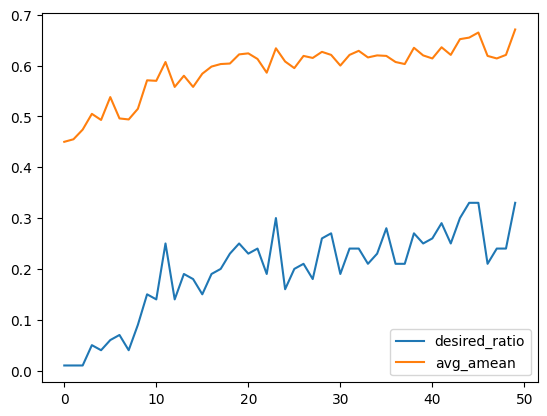

In [42]:
df_info[['desired_ratio', 'avg_amean']].plot.line()

We can see that in this case our model reached a plateu of around 30% of desired molecules among the generated sample of 1000 in each iteration. Not bad, but also not great either. **This value will definitely vary with the different parameters in different groups. Who has the highest desirablity?**

In [43]:
agent = SequenceRNN(voc, is_lstm=True)
agent.loadStatesFromFile(f'{MODEL_DIR_RL}/P08908_reinforced.pkg')
generated = agent.generate(num_samples=1000, evaluator=environment)
generated

Generating molecules:   0%|          | 0/1000 [00:00<?, ?it/s]

,SMILES,Valid,Desired,QSPRpred_P08908_LIGANDS_nostereo_XGBRegressor,SA
0,CC(=O)Nc1ccc(-c2cccc(CNCCc3ccc(Cl)c(Cl)c3)c2)cc1,1.0,0.0,5.212,1.896
1,COc1ccccc1N1CCN(CCCCCCn2nnc3ccccc32)CC1,1.0,1.0,8.356,2.102
2,c1ccc(-c2cncc(CNC3CCCCC3)n2)cc1,1.0,0.0,6.124,2.015
3,COc1ccccc1OCCNCCOc1ccccc1OCc1ccccn1,1.0,1.0,8.072,2.002
4,O=C1OC(=O)c2ccccc21,1.0,0.0,6.476,1.930
...,...,...,...,...,...
995,COc1cccc(OC)c1OC(=O)CCCN1CCN(c2cccc(C)c2)CC1,1.0,0.0,7.220,2.064
996,Cc1ccccc1N1CCN(CCCCC(=O)N2CC3CCCC3C2)CC1,1.0,0.0,7.686,2.881
997,O=CNNC1CCC(c2cncc3ccccc23)CC1,1.0,0.0,6.445,2.653
998,O=C(c1ccccc1)N1CCN(Cc2ccc(Br)cc2)CC1,1.0,0.0,6.806,1.582


Now we can append these generated molecules with their predicted $pKi$ to our large data set:

In [44]:
generated["Set"] = "Reinforced"
generated.rename({"QSPRpred_P08908_LIGANDS_nostereo_XGBRegressor": "pKi_predicted"}, inplace=True, axis='columns')
df_all_sets = pd.concat([df_all_sets[df_all_sets.Set != "Reinforced"], generated])
df_all_sets.Set.unique()

array(['Generated (pretrained)', 'P08908', 'Fine-tuned', 'Reinforced'],
      dtype=object)

and plot everything:

In [45]:
mt, plt = plot_spaces(df_all_sets, "Pretrained+P08908+FT+RL", 9002, card_data=["Set", "pchembl_value_Median", "pKi_predicted"])

Dash is running on http://127.0.0.1:9002/



In [46]:
mt.getDF().to_csv(f"{PLOT_DATA_DIR}/{mt.name}.csv")

**How does the plot look like with different hyperparameters?**

**Can we find some novel potentially interesting structures below?**

In [47]:
mt, plt = plot_spaces(
    df_all_sets[df_all_sets.Set.isin(["Reinforced", "P08908"])], 
    "Pretrained+P08908+FT+RL", 
    9003, 
    color_by="pKi_predicted", 
    card_data=[
        "Set", 
        "pchembl_value_Median", 
        "pKi_predicted"
    ]
)

Dash is running on http://127.0.0.1:9003/



In [48]:
mt.getDF().to_csv(f"{PLOT_DATA_DIR}/{mt.name}.csv")

Finally, we can perform the same test as before to see if our reinforcement learning strategy lead to a significant increase in the predicted activity mean in comparison to the training set pChEMBL value mean:

In [49]:
df_all_sets[df_all_sets.Set == "Reinforced"].pKi_predicted.mean()

7.4742809999999995

In [50]:
df_all_sets[df_all_sets.Set == "P08908"].pchembl_value_Median.mean()

7.334361143523921

In [51]:
stats.ttest_ind(df_all_sets[df_all_sets.Set == "P08908"].pchembl_value_Median, df_all_sets[df_all_sets.Set == "Reinforced"].pKi_predicted, alternative="less")

TtestResult(statistic=-3.655535310149855, pvalue=0.00012981219186880186, df=4426.0)

The test is significant, but the actual difference in means is moderate. When we plot the histogram of the predicted values it seems we have hit a "wall" on the predicted $pKi$ and it would not go over 8 easily:

<Axes: >

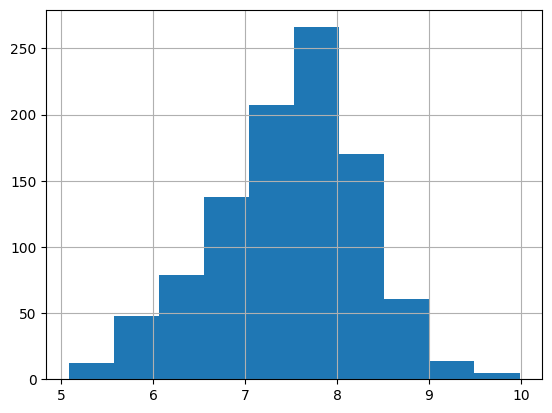

In [52]:
df_all_sets[df_all_sets.Set == "Reinforced"].pKi_predicted.hist()

This could be due to the high epsilon parameter, but it could also be due to the definition of the modifier that basically made the model see not much difference between molecules with predicted $pKi$ higher than 8:

<Axes: >

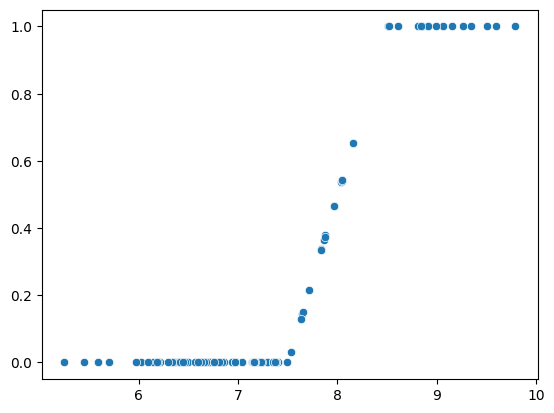

In [53]:
raw = qsprpred_scorer.getScores(sample)
modified = qsprpred_scorer(sample)
sns.scatterplot(x=raw, y=modified)

However, this distribution still has enrichment over the original distribution of activities:

<Axes: >

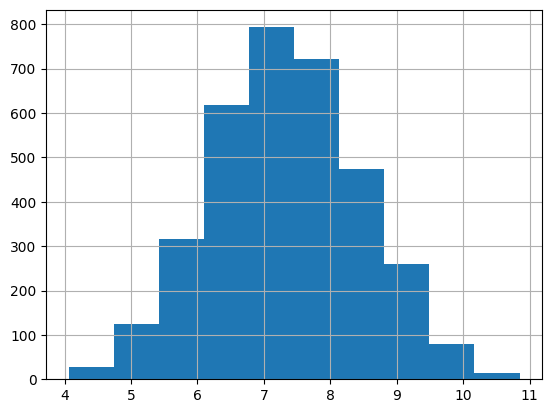

In [54]:
df_all_sets[df_all_sets.Set == "P08908"].pchembl_value_Median.hist()